In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from galaxybrain.data_utils import MouseData
from galaxybrain.plot_utils import rc_style, pltlabel
rc_style()
from galaxybrain import ramsey 
mice_data = MouseData()

Mouse 1
Grabbing Spikes...
Binning Spikes...
[('CP', 176), ('FrMoCtx', 78), ('HPF', 265), ('LS', 122), ('MB', 127), ('SC', 42), ('SomMoCtx', 91), ('TH', 227), ('V1', 334)] Total: 1462
Mouse 2
Grabbing Spikes...
Binning Spikes...
[('FrCtx', 31), ('FrMoCtx', 647), ('HPF', 333), ('LS', 133), ('MB', 40), ('RSP', 112), ('SC', 98), ('SSCtx', 50), ('SomMoCtx', 220), ('TH', 638), ('UNK', 11), ('V1', 251), ('V2', 124)] Total: 2688
Mouse 3
Grabbing Spikes...
Binning Spikes...
[('CP', 134), ('FrMoCtx', 86), ('HPF', 155), ('LH', 4), ('LS', 4), ('RSP', 10), ('SomMoCtx', 10), ('TH', 1878), ('UNK', 15)] Total: 2296


# Data Diagnostic + Supplementary result Figures

## Raw mouse data

### Firing rate over time
#### <span style="color:orange">make sure time is in ms</span>


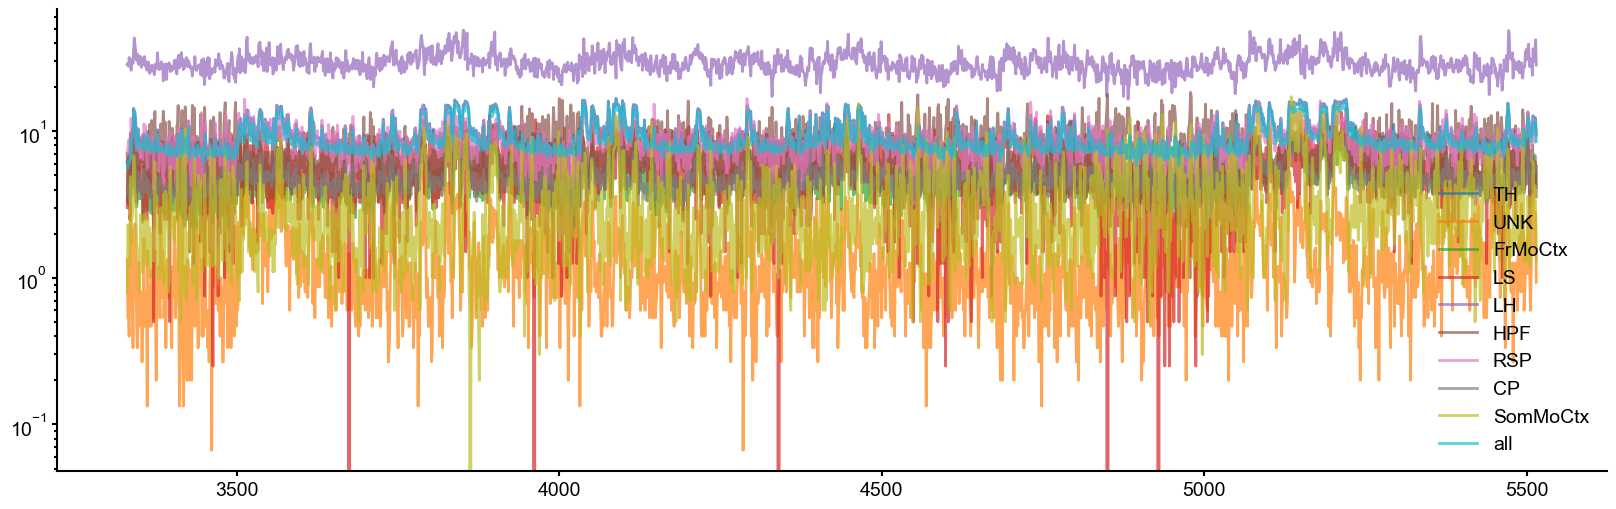

In [18]:
# check over time
i_mouse = 'waksman'
BURN_IN = 20
# total spikes over time
plt.figure(figsize=(20,6))
region_indices = mice_data.raster_dict[i_mouse][1]
region_data = mice_data.raster_dict[i_mouse][0]
region_indices['all'] = np.hstack([region_indices[k] for k in region_indices]) # redundant but easier for later operations
for reg, ixs in region_indices.items():
    # normalize by number of cells present
    plt.plot(region_data.index[BURN_IN:-BURN_IN], region_data[ixs].sum(1).values[BURN_IN:-BURN_IN]/len(ixs), '-', label=reg, alpha=0.7)
plt.legend()
plt.yscale('log')

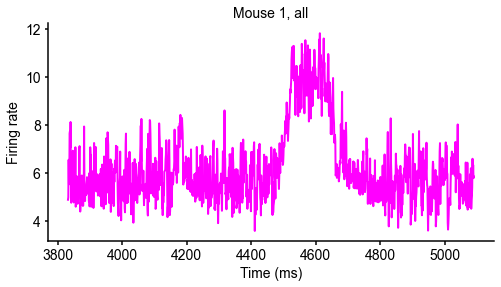

In [47]:
plt.figure(figsize=(8,4))
reg = 'all'
ixs = region_indices[reg]
plt.plot(mice_data.raster_dict[i_mouse][0][0].index[BURN_IN:-BURN_IN], 
         mice_data.raster_dict[i_mouse][0][0][ixs].sum(1).values[BURN_IN:-BURN_IN]/len(ixs),
        color='magenta')
# plt.yscale('log')
pltlabel(f'Mouse 1, {reg}', 'Time (ms)', 'Firing rate')
plt.savefig('../fig/mouse/sample_ts.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

## Spike raster

/var/folders/xc/7yy4pnhj7vs66gsxgymx9ffr0000gn/T/ipykernel_58594/1841415091.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.array(all_spikes[i_mouse][0][0]))[burn_in:-burn_in,:].T, aspect='auto')


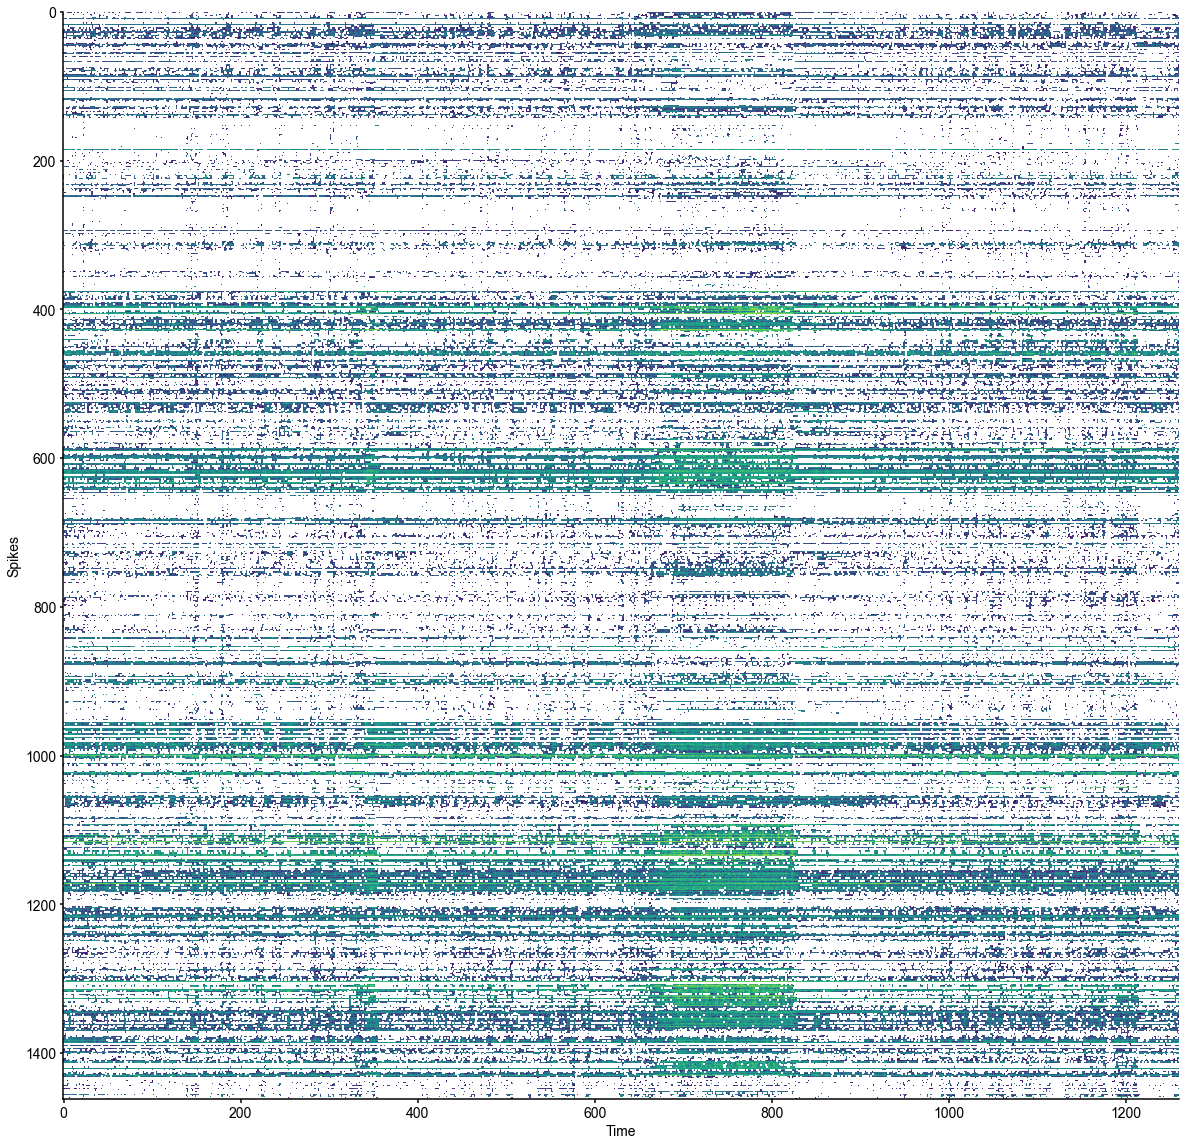

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(np.log10(np.array(mice_data.raster_dict[i_mouse][0][0]))[BURN_IN:-BURN_IN,:].T, aspect='auto')
plt.xlabel('Time'); plt.ylabel('Spikes')
plt.show()

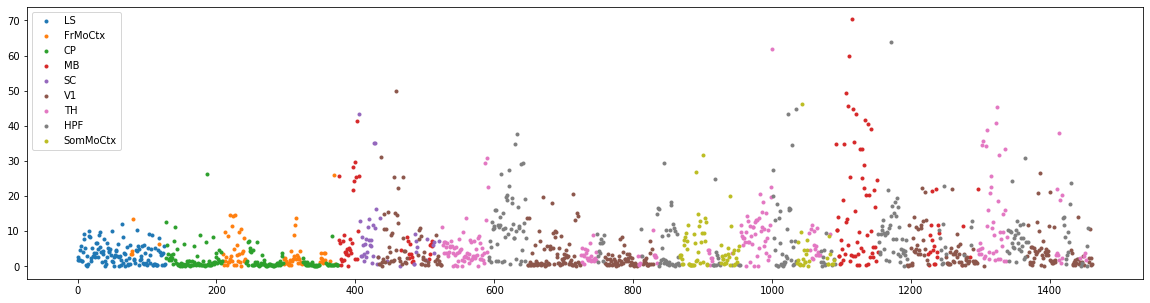

In [32]:
# check over cells
plt.figure(figsize=(20,5))
for k,v in mice_data.raster_dict[i_mouse][0][1].items():
    plt.plot(v, mice_data.raster_dict[i_mouse][0][0][v].mean(0), '.', label=k)

plt.legend()

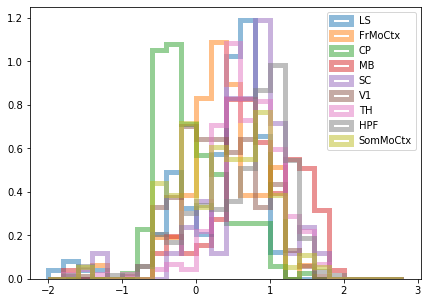

In [33]:
## Distribution of spike count?
plt.figure(figsize=(7,5))
for k,v in mice_data.raster_dict[i_mouse][0][1].items():
    plt.hist(np.log10(mice_data.raster_dict[i_mouse][0][0][v].mean(0)), bins=np.arange(-2,3,0.2), label=k, density=True, alpha=0.5, lw=5,histtype='step')
    
plt.legend()

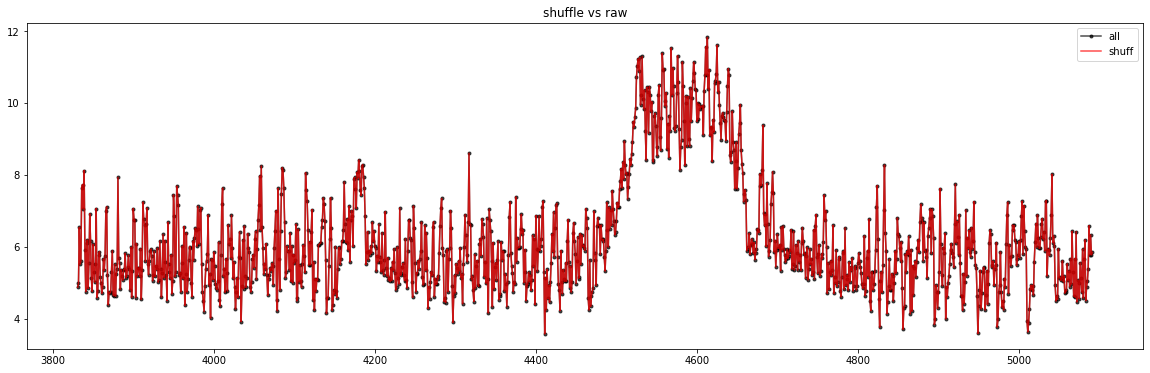

In [30]:
from galaxybrain.analysis_pipe import shuffle_data

plt.figure(figsize=(20,6))
shuffled = shuffle_data(mice_data.raster_dict[i_mouse][0][0],'space')
plt.plot(mice_data.raster_dict[i_mouse][0][0].index[BURN_IN:-BURN_IN], mice_data.raster_dict[i_mouse][0][0].sum(1).values[BURN_IN:-BURN_IN]/mice_data.raster_dict[i_mouse][0][0].shape[1], 'k.-', label='all', alpha=0.7)
plt.plot(shuffled.index[BURN_IN:-BURN_IN], shuffled.sum(1).values[BURN_IN:-BURN_IN]/shuffled.shape[1], 'red', label='shuff', alpha=0.7)
plt.title('shuffle vs raw')
plt.legend()

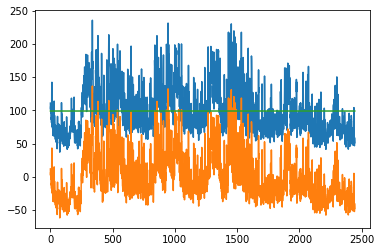

In [261]:
from sklearn.decomposition import PCA
from neurodsp.spectral import compute_spectrum

i_mouse = 1
subset_size = 150
n_pc = int(0.9*subset_size)

data = np.array(mice_data.raster_dict[i_mouse][0])[BURN_IN:-BURN_IN] #shape (2446, 2688)
pca = PCA(n_components=n_pc)
rand_inds = np.sort(np.random.choice(data.shape[1], subset_size, replace=False))
data_subset = data[:,rand_inds]

# DONT TRANSPOSE DATA MATRIX TO HAVE THE CORRECT TIME DIMENSIONS
pca.fit(data_subset)


f_axis, psd = compute_spectrum(data_subset.mean(1), fs=1, nperseg=120, noverlap=60, avg_type='mean')

X_proj = pca.fit_transform(data_subset)

# X transformed (X_proj) is the same as X@pca.components_, (pca.components_ are the eigenvectors)
# plt.plot((data_subset@pca.components_.T)[:,0])
# plt.plot(X_proj[:,0])
# plt.plot((data_subset@pca.components_.T)[:,0]-X_proj[:,0])

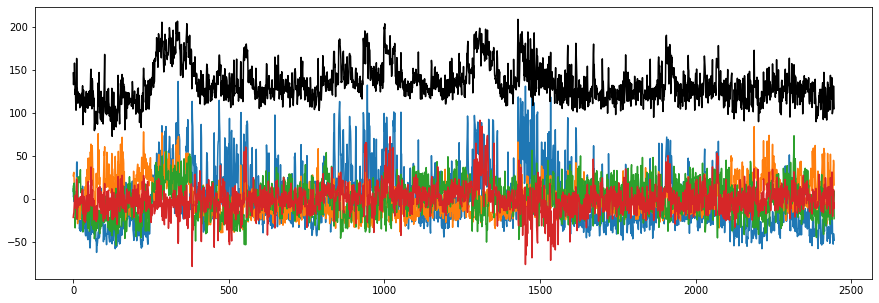

In [270]:
from scipy.stats import zscore
pca.fit(data_subset.T)
pca.components_.shape
plt.figure(figsize=(15,5))
plt.plot(X_proj[:,0:4])
#plt.plot(pca.components_[:1].T, alpha=0.8)
plt.plot(data_subset.mean(1)*20, 'k-')

# Avalanche analysis
```python
spike_count = np.asarray(compute_spike_count(X)) # number of nonzero cells for each neuron
threshold = activity_threshold * X.shape[1] / 100 # scalar disabled for now
spike_count[spike_count < threshold] = 0

# Avalanche size and duration
# Get the non zero indices
aval_idx = np.nonzero(spike_count)[0] # index because nonzero is tuple
```



### parametrizing
sweep over range of theta (0, max) and choose where its log normal is mu - 2sigsweep over range of theta (0, max) and choose where its log normal is mu - 2sig

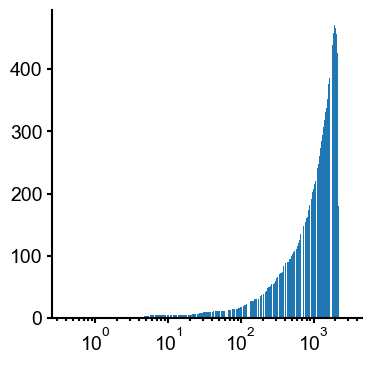

In [19]:
from complexnetwork.avalanche import Avalanches

def line_hist(data, title, bins=12):
    y, binEdges = np.histogram(data, bins=bins)
    bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])
    plt.loglog(bincenters, y, '-', c='black')
    plt.title(title)
    plt.show()
    
sample = mice_data.raster_dict['waksman'][0]

distr = []
pop_vector = np.array(sample.sum(1))[BURN_IN:-BURN_IN]
for th in range(0,3000):
    spike_count, avalanche_durations, avalanche_sizes, iai = Avalanches().avalanche_observables(sample.T, th)
    distr.append(len(avalanche_sizes))
distr = distr[:np.argmin(distr)] # remove zeros on right tail

# plot theta vs # avalanches
plt.bar(range(len(distr)), distr) #, marker='-o'
plt.xscale('log')


# line_hist(avalanche_durations, 'durations')
# line_hist(avalanche_sizes, 'sizes')

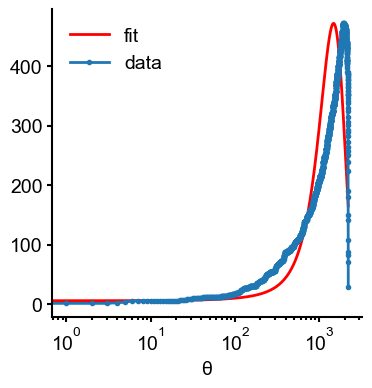

In [52]:
# fit with reverse bin approach
from scipy import stats

counts, bin_centers = np.array(distr), np.linspace(0, len(distr)+0, len(distr)) # where bins are bin edges on x axis
# restore data from hist: count multiplied bin centers
restored = [[d]*int(counts[n]) for n,d in enumerate(bin_centers)]
# flatten result
restored = np.hstack(np.array(restored))

dist = stats.lognorm(*stats.lognorm.fit(restored))
x = np.arange(0,max(bin_centers))
y = dist.pdf(x)
# PDF is normalized, so scale it to match hist
y= y/y.max()
y = y*counts.max()

plt.plot(x,y,'r', lw=2, label='fit')
plt.plot(bin_centers, distr, '-o', label='data')
plt.xlabel(r'$\theta$')
plt.xscale('log')
plt.legend()
plt.show()


(array([  7.,  27.,  95., 183., 286., 202., 142.,  49.,   7.,   2.]),
 array([-5.46211002, -4.10158317, -2.74105633, -1.38052948, -0.02000264,
         1.34052421,  2.70105106,  4.0615779 ,  5.42210475,  6.78263159,
         8.14315844]),
 <BarContainer object of 10 artists>)

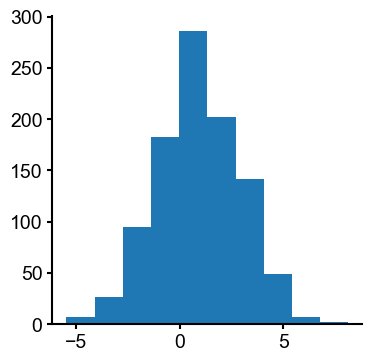

In [55]:
from scipy.stats import norm
a, b = 1., 2.

x = norm.rvs(a, b, size=1000, random_state=123)


plt.hist(x)

## fitting using optimize

In [2]:
from scipy.optimize import curve_fit


def func(x, s, m):
    """lognorm"""
    return (1/(s*x*np.sqrt(2*np.pi))) * np.exp(-(np.log(x-m)**2)/(2*s**2))
    
popt, pcov = curve_fit(func, bin_centers, distr)
# plt.plot(log_x, distr, '-o')
plt.plot(bin_centers, func(bin_centers, *popt), '-o', color='orange')



NameError: name 'bin_centers' is not defined

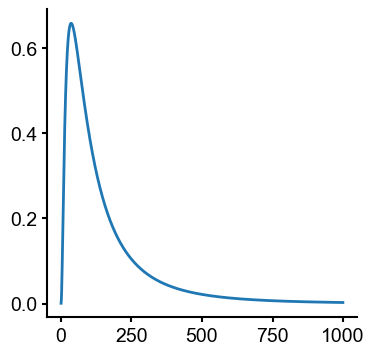

In [48]:
x = np.linspace(0,10,1000)
plt.plot(func(x,1,0))
# plt.plot(func(np.log(x),1,0))

# plt.xscale('log'c)

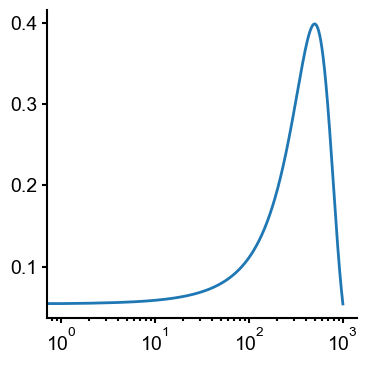

In [14]:
import numpy as np

def normal(x):
    mu, sigma = 0, 1
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu)/sigma)**2)


x = np.linspace(-2,2,1000)

plt.plot(normal(x))
plt.xscale('log')
    

In [ ]:
activity_threshold = 80
X = sample.T
from complexnetwork.utils import compute_spike_count
spike_count = np.asarray(compute_spike_count(X))
threshold = activity_threshold * X.shape[1] / 100
print(threshold)
spike_count[spike_count < threshold] = 0

1780.8


Text(0, 0.5, '# avalanches')

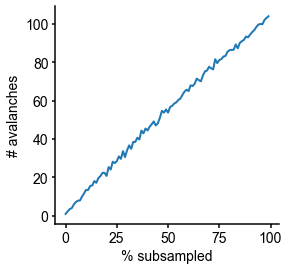

In [126]:
# on smaller size
num_avalanches = []
for subset_size in np.linspace(2, sample.shape[1], 100, dtype=int):
    curr_num = []
    for i in range(10):
        loc_array = np.sort(np.random.choice(sample.shape[1], subset_size, replace=False))
        subset = np.array(sample.iloc[:,loc_array])

        _, avalanche_durations, avalanche_sizes, _ = Avalanches().avalanche_observables(np.array(subset.T), threshold_estimator(subset))
        curr_num.append(len(avalanche_durations))
    num_avalanches.append(np.mean(curr_num))

plt.plot(num_avalanches)
plt.xlabel('% subsampled')
plt.ylabel('# avalanches')

# Supplementary figs: Firing rate vs. Exponent vs. Offset

move to sep notebook?

all
CP
HPF
LS
MB
TH
V1


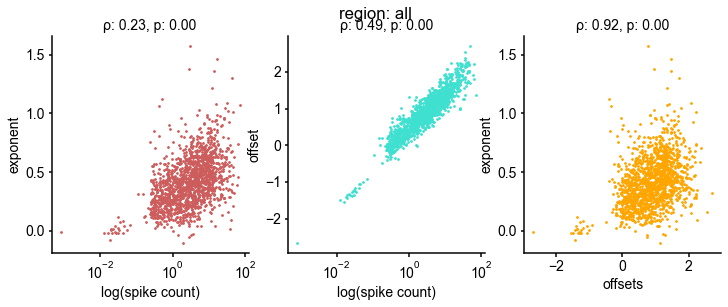

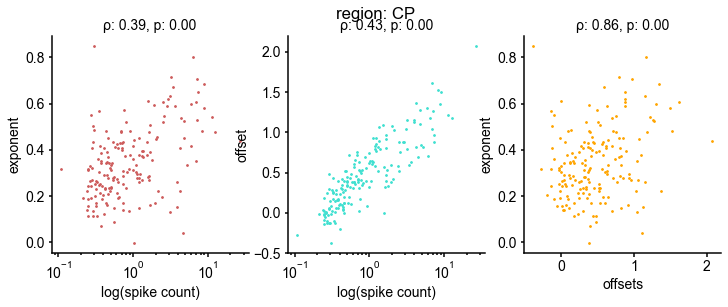

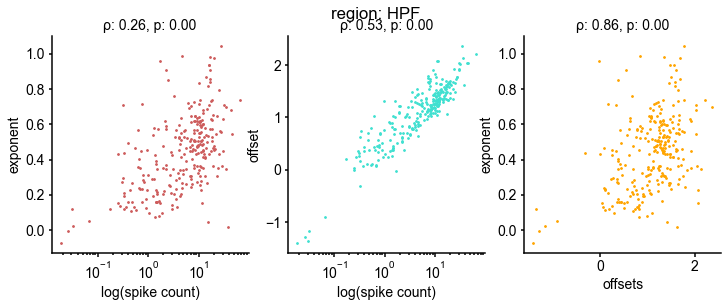

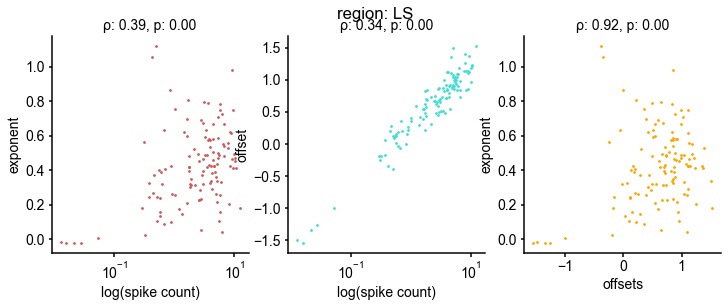

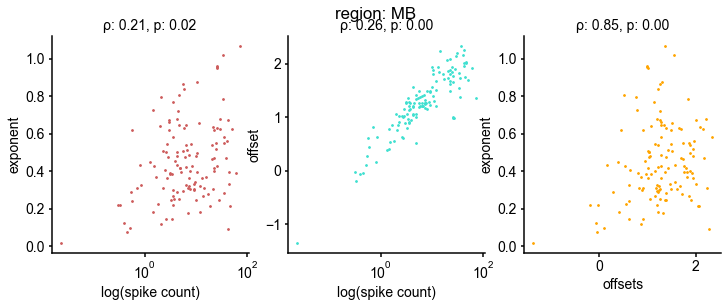

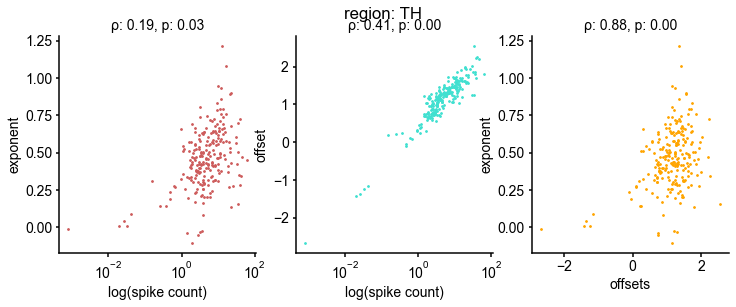

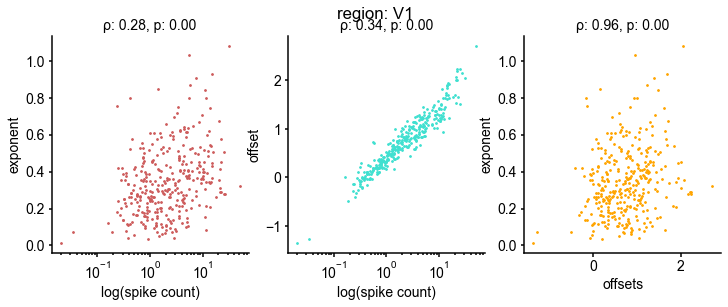

In [139]:
raster_dict = spike_dict([0])
mouse_key = 'krebs'
BURN_IN = 20 #use for later things 
ft_kwargs = {'fs':1, 'nperseg':120, 'noverlap':60}

from neurodsp.spectral import compute_spectrum

mouse_data = mouse_iter(raster_dict, mouse_key, BURN_IN)
fg = FOOOFGroup(max_n_peaks=0, aperiodic_mode='fixed', verbose = False)

### CONVERT TO FIRING RATE
for mouse_raster, region_name, region_count in mouse_data:
    total_spikes = mouse_raster.sum(0)
    fr = total_spikes/len(mouse_raster)
    freqs, powers_chans = compute_spectrum(mouse_raster.T, **ft_kwargs)
    fg.fit(freqs, powers_chans) 
    exponents = fg.get_params('aperiodic_params', 'exponent')
    offsets = fg.get_params('aperiodic_params', 'offset')
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.scatter(fr, exponents, color='indianred', s=3);     plt.xscale('log')
    pltlabel(f'ρ: {rho:.2f}, p: {p:.2f}', 'log(spike count)', 'exponent')
    rho, p = stats.spearmanr(total_spikes, exponents)

    plt.subplot(1,3,2)
    plt.scatter(fr, offsets, color='turquoise', s=3);     plt.xscale('log')
    pltlabel(f'ρ: {rho:.2f}, p: {p:.2f}', 'log(spike count)', 'offset')
    rho, p = stats.spearmanr(total_spikes, offsets)
    
    plt.subplot(1,3,3)
    plt.scatter(offsets, exponents, color='orange', s=3);     #plt.xscale('log')
    pltlabel(f'ρ: {rho:.2f}, p: {p:.2f}', 'offsets', 'exponent')
    rho, p = stats.spearmanr(offsets, exponents)
    
    plt.suptitle(f'region: {region_name}')

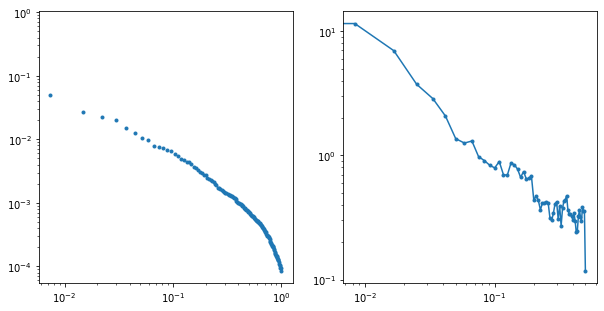

In [220]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(np.arange(n_pc)/n_pc, pca.explained_variance_ratio_, '.')
plt.subplot(1,2,2)
plt.loglog(f_axis, psd, '.-')

notes: 
- when n_pc is close to subset size, the last few eigenvalues become very small
- **crazy**: random.choice() chooses with replacement, which repeats some indices, hence enforcing the eigenvalues to be VERY small (near zero) for high subset size
    - solution: in random.choice(replace=False)
- fit up to 200 eigenvalues maximum or 50th percentile of the e-vales
    - question: is the slow roll-off at higher evals interesting or not?
    - PLOT the eigenspectrum plot where the xaxis is not the rank of PC, but proportion of n_pc (i.e., 0 to 1)
- NEVERMIND[TRANSPOSE DATA MATRIX TO HAVE THE CORRECT TIME DIMENSIONS]

In [14]:
for region_name, region_count in zip(['all', 'V1','HPF','LS'], [1462,334,265,122]):
    mouse_key = 'krebs'
    BURN_IN = 20
    mouse = mice_data.raster_dict[mouse_key][0]
    if region_name == 'all':
        mouse_raster = mouse[0].iloc[BURN_IN:-BURN_IN]
    else:
        mouse_raster = mouse[0][mouse[1][region_name]].iloc[BURN_IN:-BURN_IN] #mouse[1] are indices
    subsetsizes = np.linspace(30,region_count,16, dtype=int)
    ramsey_params = {'n_iters' : 2, 'n_pc' : 0.8, 'f_range' : [0,0.4]}

    eigs, powers, pca_m, space_er, ft_m, time_er,\
    pearson_r, spearman_rho, pearson_p, spearman_p, \
    pca_b, ft_b, pc_range_history = ramsey.ramsey(mouse_raster, subsetsizes, **ramsey_params)
    
    r_i = 2 # random index of subset size
    model = lambda x: (10**offset)*x**-exp
    plt.figure(figsize=(7,7))
    for i in range(2):
        exp = pca_m[:,r_i][i] #.mean(0)
        offset = pca_b[:,r_i][i] #.mean(0)
        _eigs = eigs[r_i]
        x = np.arange(*pc_range_history[r_i]) #np.arange(len(eigs))
        plt.loglog(x, model(x),color='red',alpha=0.8,lw=2)
        plt.loglog(_eigs,color='blue')

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Looking at linear fits

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


<Figure size 504x504 with 0 Axes>

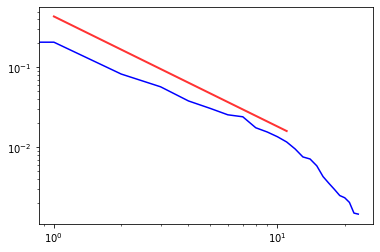

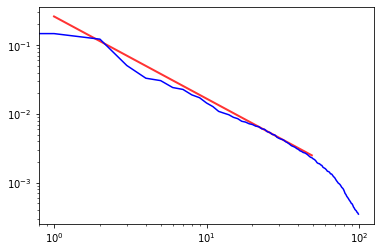

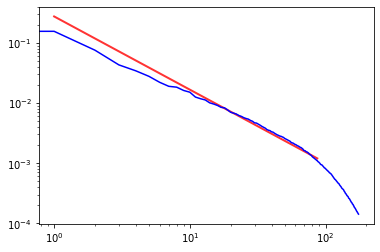

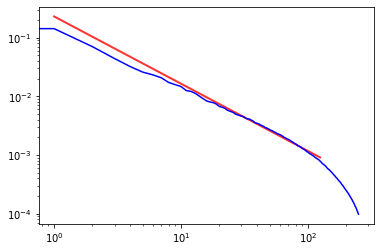

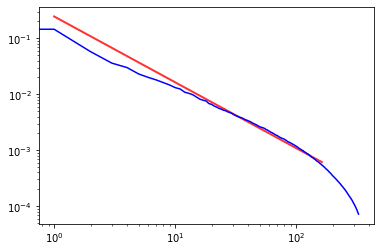

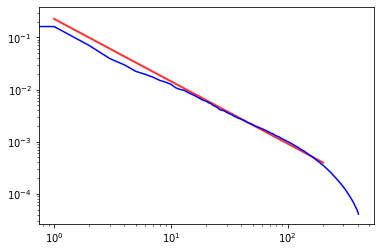

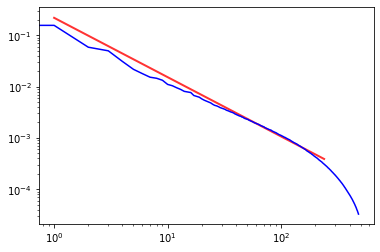

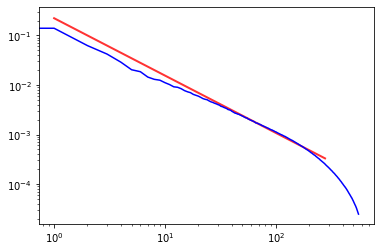

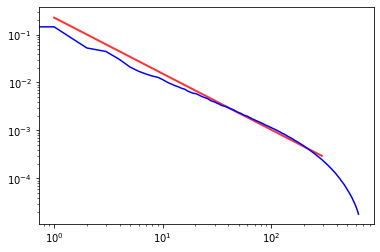

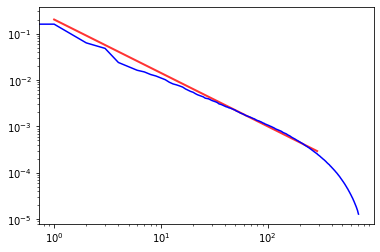

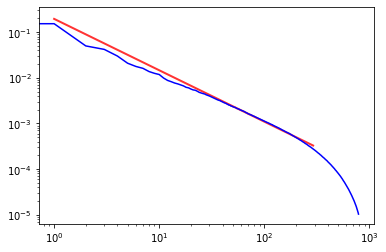

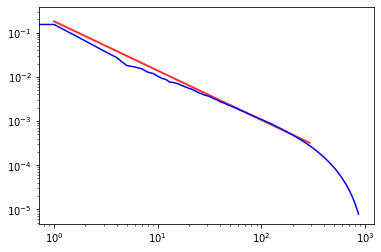

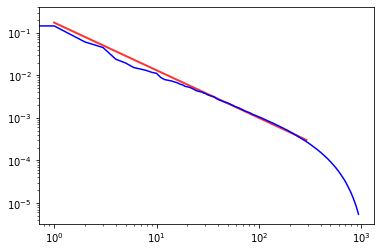

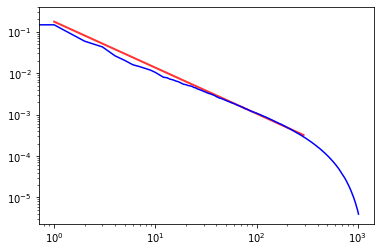

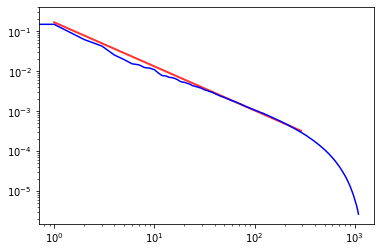

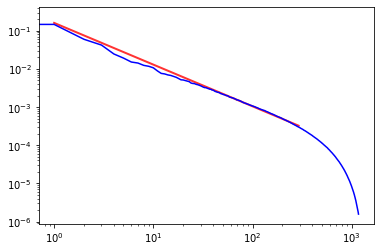

In [23]:
r_i = 2 # random index of subset size
model = lambda x: (10**offset)*x**-exp
plt.figure(figsize=(7,7))
i=0 # iter index
for r_i in range(16):
    plt.figure()
    exp = pca_m[:,r_i][i] #.mean(0)
    offset = pca_b[:,r_i][i] #.mean(0)
    _eigs = eigs[r_i]
    x = np.arange(*pc_range_history[r_i]) #np.arange(len(eigs))
    plt.loglog(x, model(x),color='red',alpha=0.8,lw=2)
    plt.loglog(_eigs,color='blue')

# a look at pc_range

Text(0.5, 1.0, 'curr_pc_range = [0, y]')

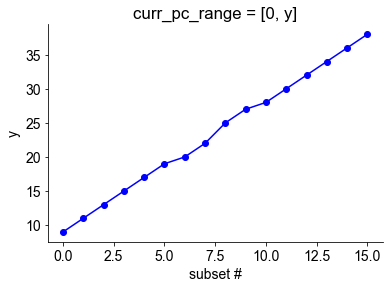

In [120]:
_data=load_results('../data/experiments/expTIMESLOPE',mice=['krebs'], type_='mouse')
data = _data['krebs'][3] # 'all' index
plt.plot(data[2]['curr_pc_range'][:,1], 'o-', color='b'); 
plt.xlabel('subset #');    plt.ylabel('y');      plt.title('curr_pc_range = [0, y]')

# PCA vs SVD

- to to turn singular values into variance explained, would have to "Divide each squared singular value by the sum of all squared singular values. This will give you the proportion of variance explained by each principal component."

Mouse 1
Grabbing Spikes...
Binning Spikes...
[('CP', 176), ('FrMoCtx', 78), ('HPF', 265), ('LS', 122), ('MB', 127), ('SC', 42), ('SomMoCtx', 91), ('TH', 227), ('V1', 334)] Total: 1462


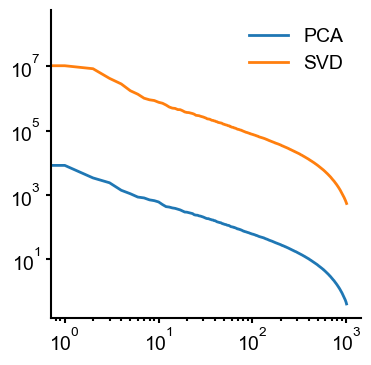

In [5]:
from sklearn.decomposition import PCA

m = MouseData(['krebs'])
mdf = m.get_spikes('krebs')
pca = PCA(n_components=int(0.8*min(mdf.shape)))
pca_res = pca.fit(mdf)
var = pca_res.explained_variance_
s = np.linalg.svd(mdf.T, compute_uv=False)

plt.loglog(var, label='PCA')
plt.loglog(np.square(s)[:1009], label='SVD')
plt.legend()